## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## imports

In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
from ipywidgets import interact, interactive, fixed

%matplotlib inline


# Load chessboard images
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)


## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

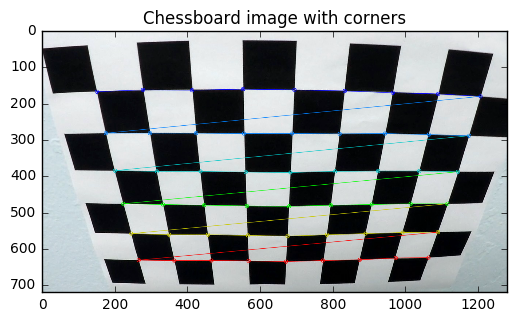

In [2]:
# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard image with corners")
    plt.show()

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
chessboards = [] # array of chessboard images to look at later

# Step through the list and search for chessboard corners
for i in range(1,21):
    fname = 'camera_cal/calibration{}.jpg'.format(i)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(img)
        chessboards.append(img)
        

camera_cal/calibration2.jpg
camera_cal/calibration3.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration20.jpg


In [4]:
def browse_chessboards(chessboards):
    n = len(chessboards)
    def view_image(i):
        plt.imshow(chessboards[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Chessboard: %d' % i)
        plt.show()
    interact(view_image, i=(0,n-1))

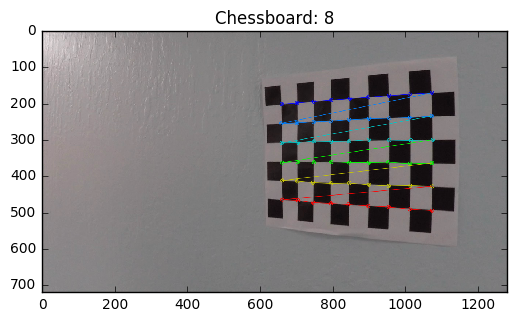

In [5]:
%matplotlib inline    
browse_chessboards(chessboards)

## Apply a distortion correction to raw images.

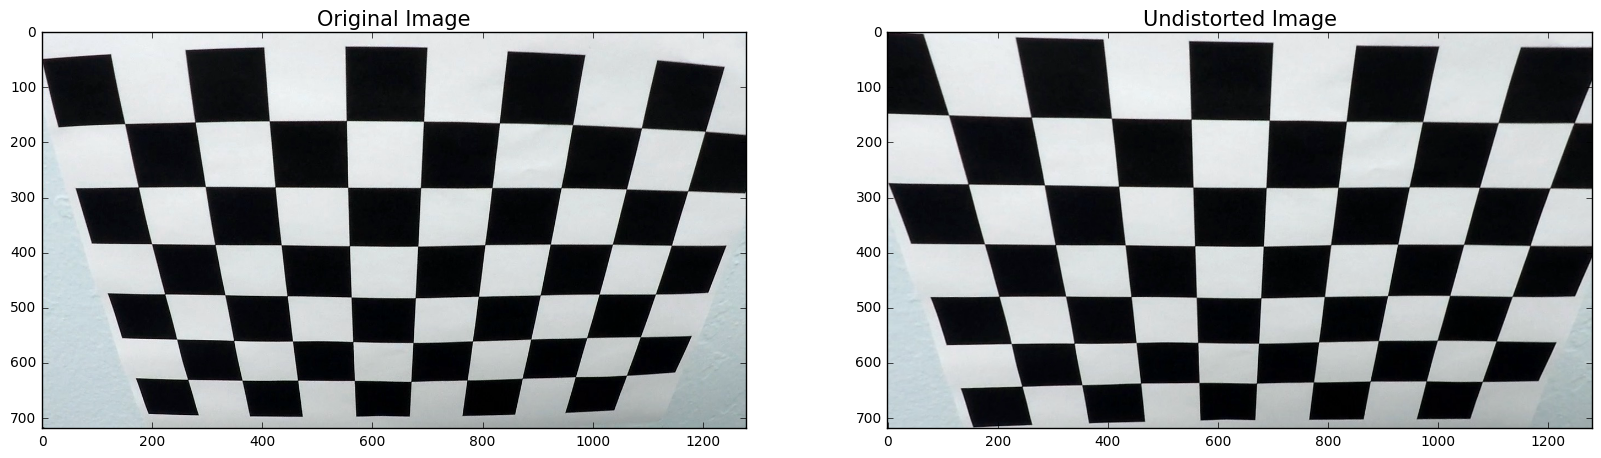

In [6]:
# Test undistortion on an image
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('output_images/checker_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=15)


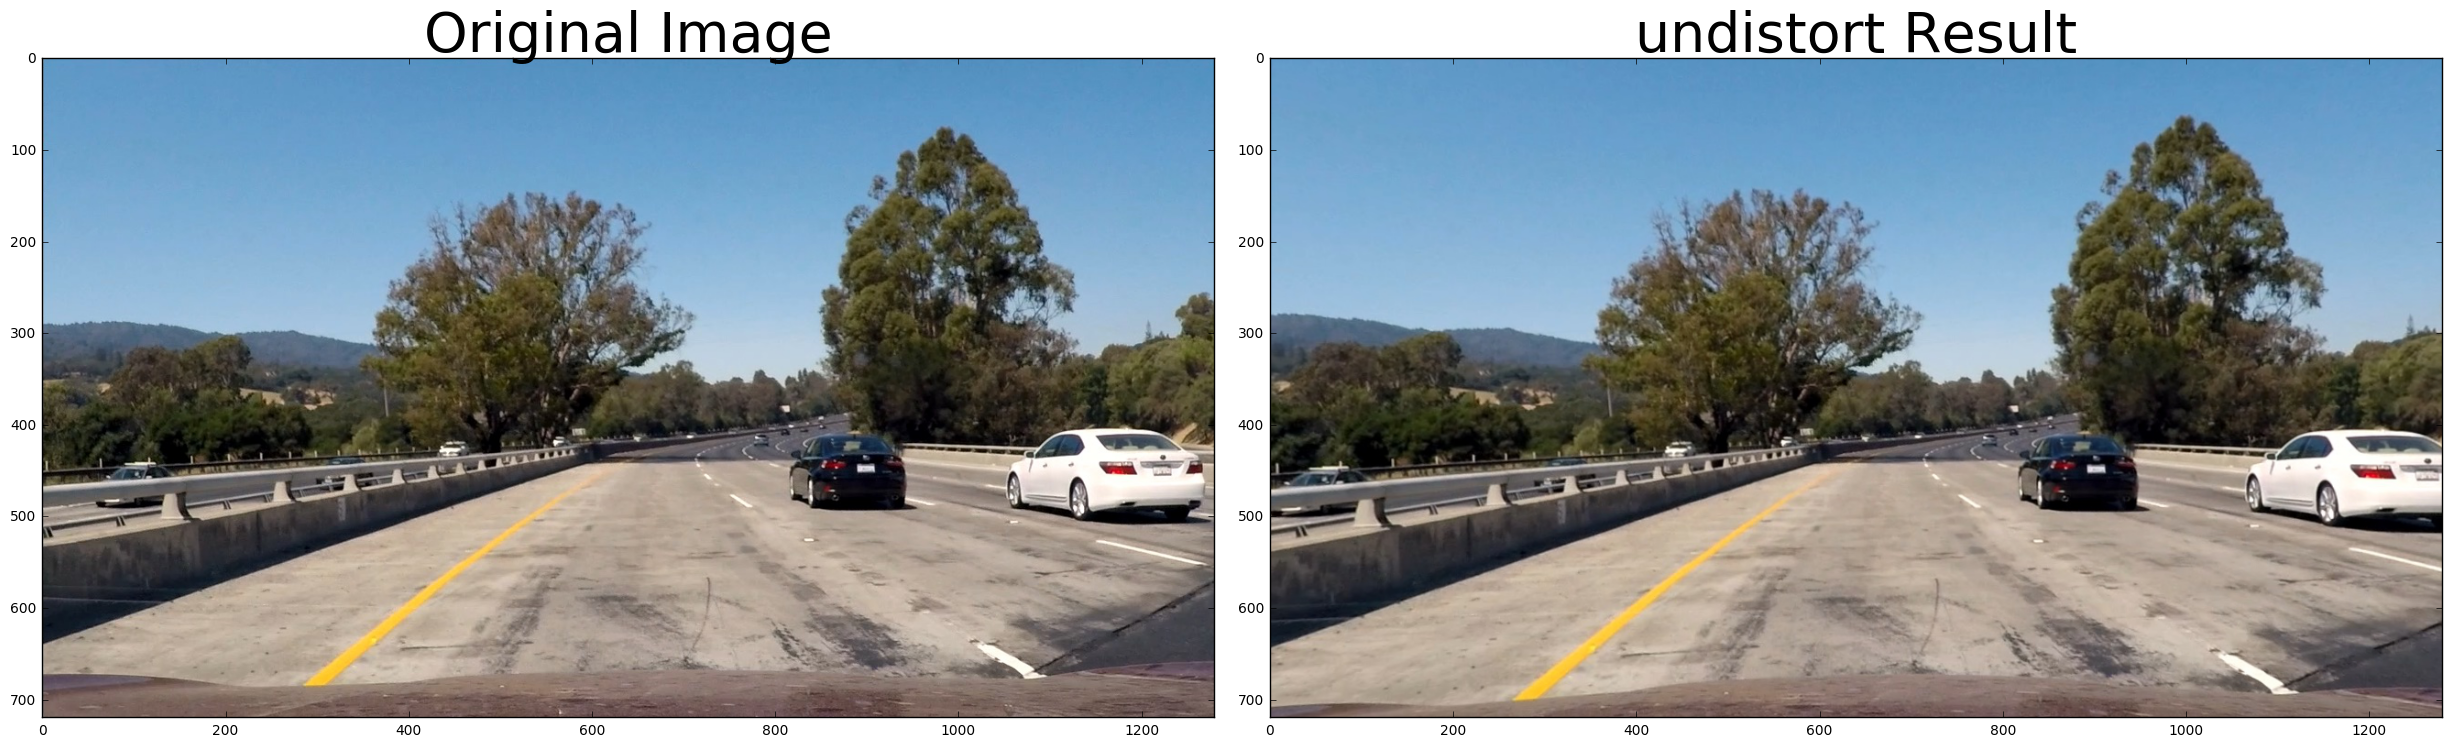

In [7]:
# Visualize undistortion or image


dst = cv2.undistort(img, mtx, dist, None, mtx)

for i in range(1,2):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    image_origRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = cv2.undistort(image, mtx, dist, None, mtx)
    image_dstRGB = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image_origRGB)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(image_dstRGB, cmap='gray')
    ax2.set_title('undistort Result', fontsize=40)

   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## edge detection

In [8]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

print("Functions for edge dections are created")

Functions for edge dections are created


In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

print("function for masking region of interest")

function for masking region of interest


## pipeline function
takes in an image and outputs a binary image to help lanefinding

In [10]:
# Edit this function to create your own pipeline.
def pipeline(img):  
    
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    # Convert to HLS color space and separate the S saturation channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Define sobel kernel size
    ksize = 7
    
    # Apply thresholding functions 
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    
    # Create a combined image
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary



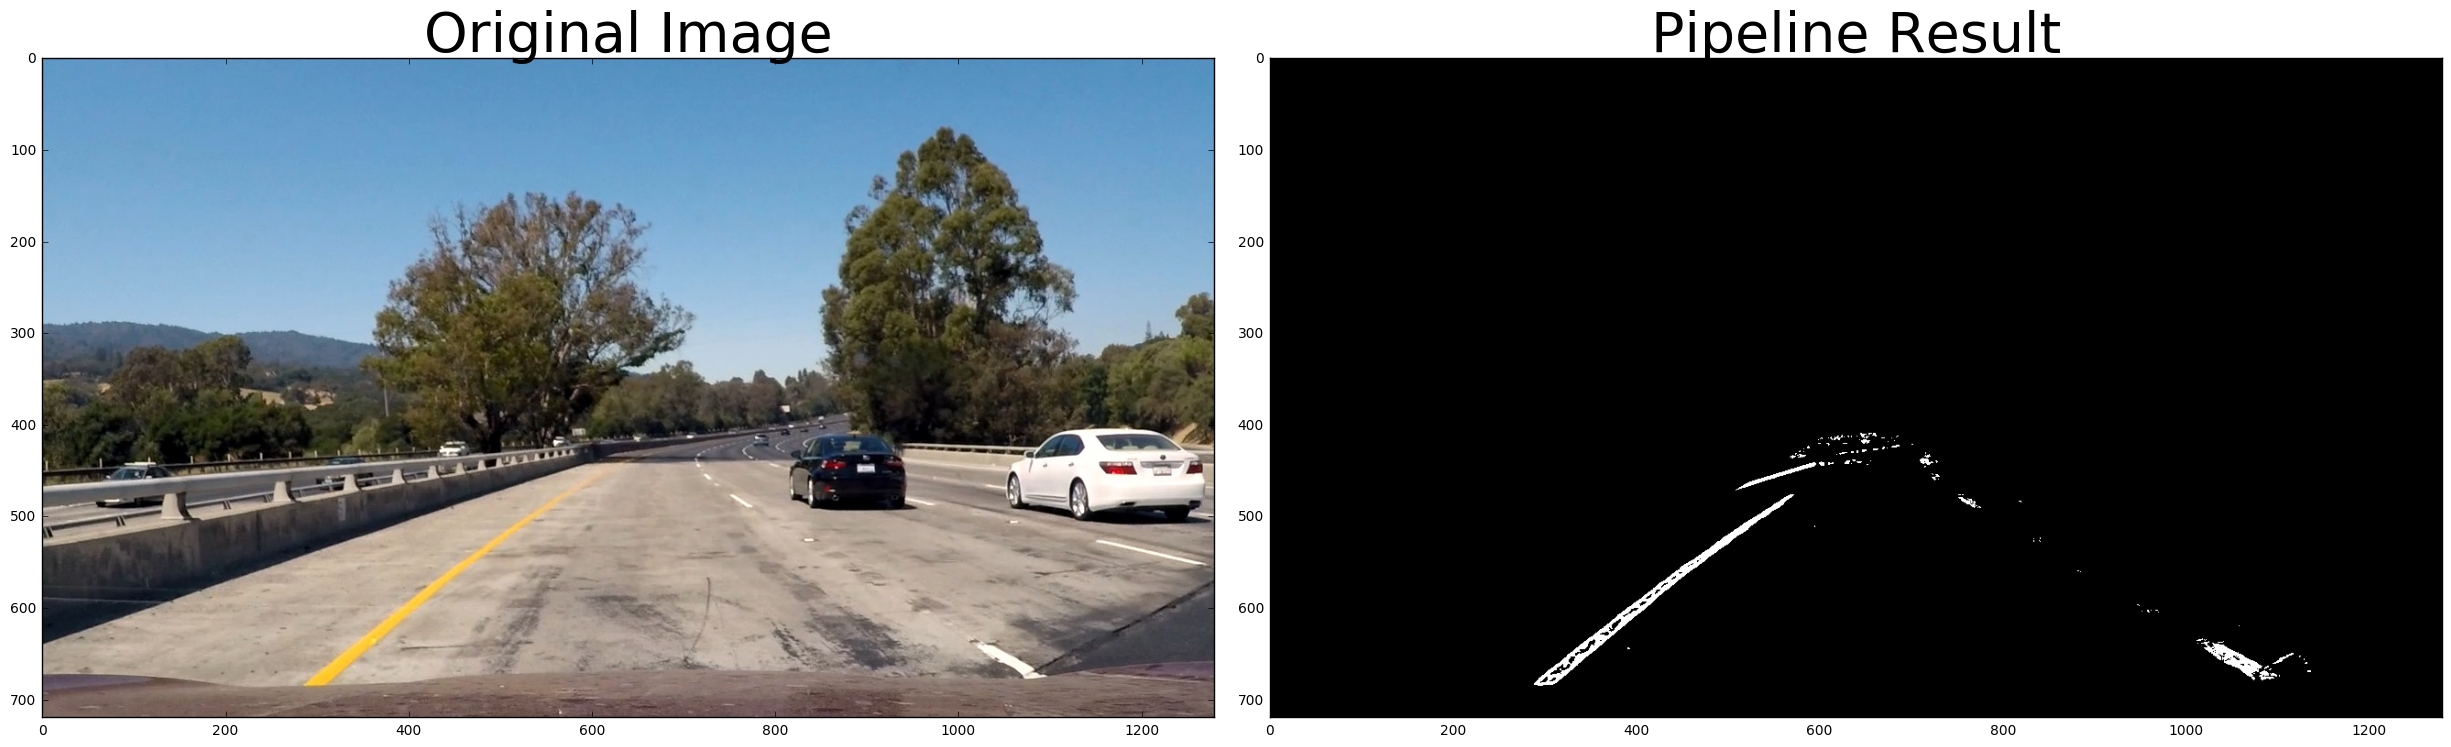

In [11]:
for i in range(1,2):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    image_origRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pipeline(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image_origRGB)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)

   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## perspective transform

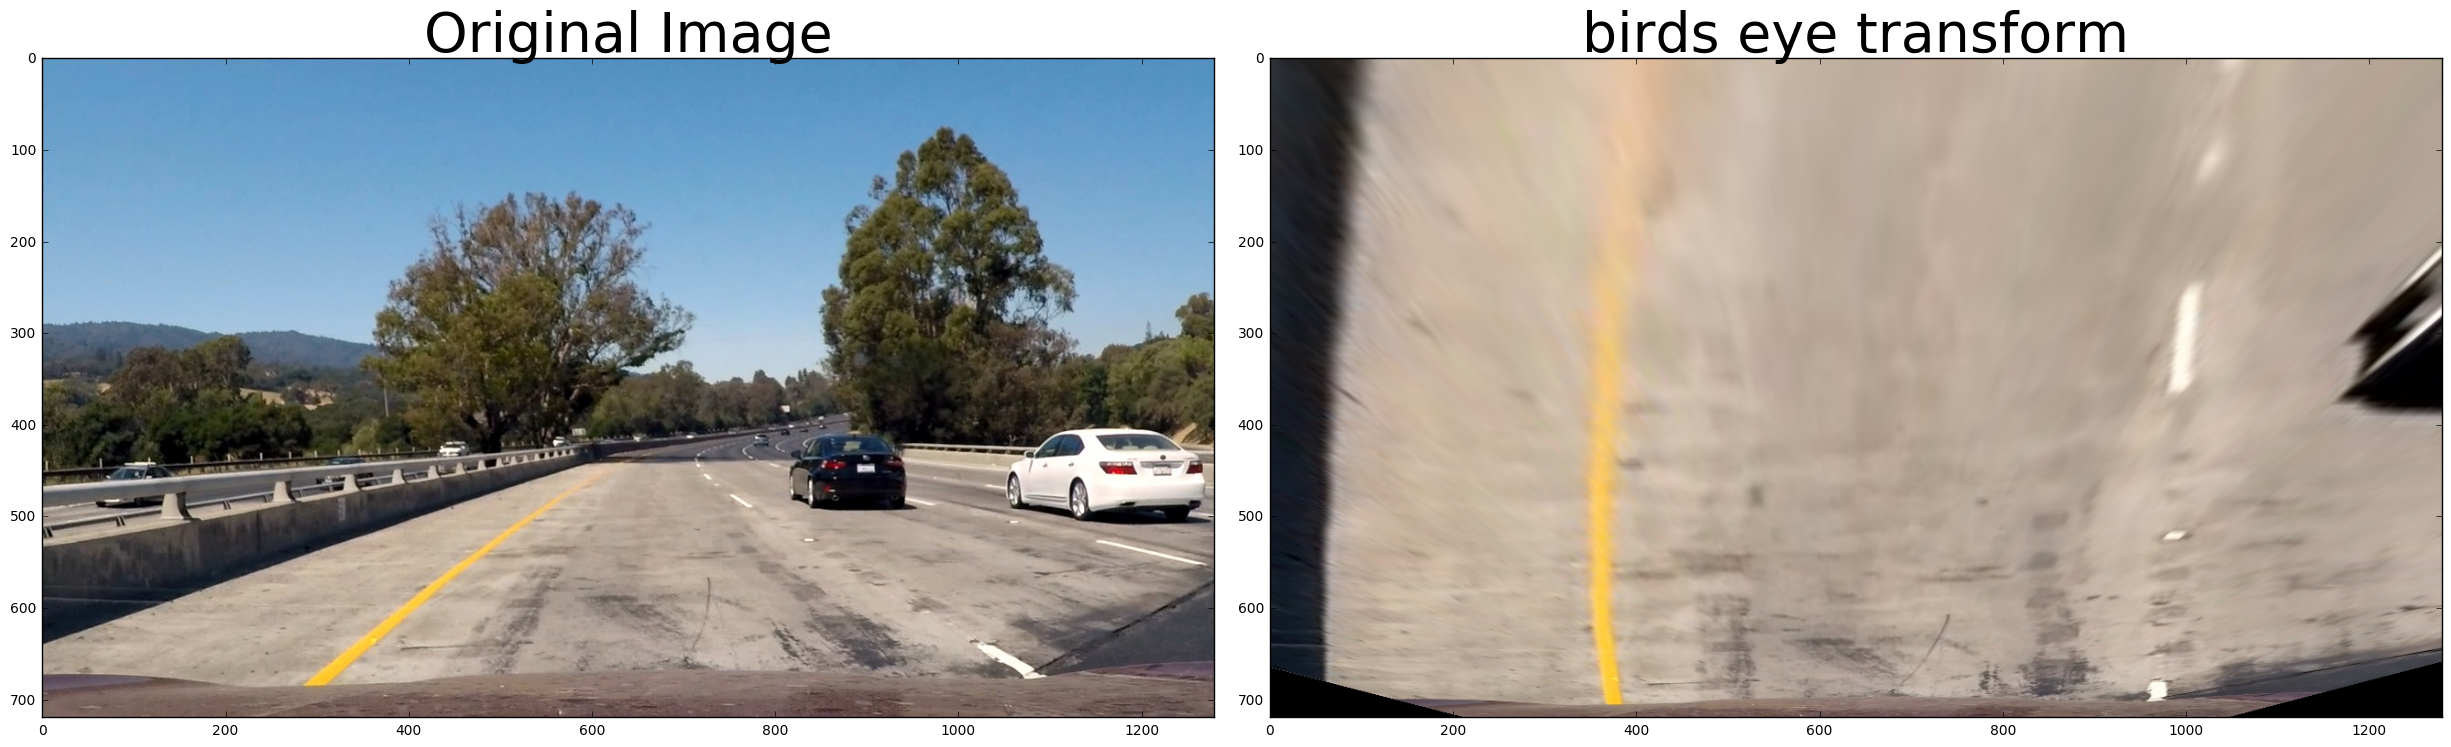

In [12]:
def birds_eye(image):  
    #undistort
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)

    # Apply pipeline to the image to create black and white image
    binary_undistorted = pipeline(undistorted)

    # For source points use the outer four detected corners
    src = np.float32([[580,460],[710,460],[1150,720],[150,720]])

    # For destination points, pick some points to be
    # a decent fit for displaying the warped result 
    dst = np.float32([[310, 0],[960, 0],[960, 720],[310, 720]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    birds_eye = cv2.warpPerspective(image, M, img_size)
    
    return birds_eye

for i in range(1,2):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    image_origRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = birds_eye(image)
    resultRGB = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image_origRGB)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(resultRGB, cmap='gray')
    ax2.set_title('birds eye transform', fontsize=40)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## find and draw left and right lane lines with polynomial

/Users/jason/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


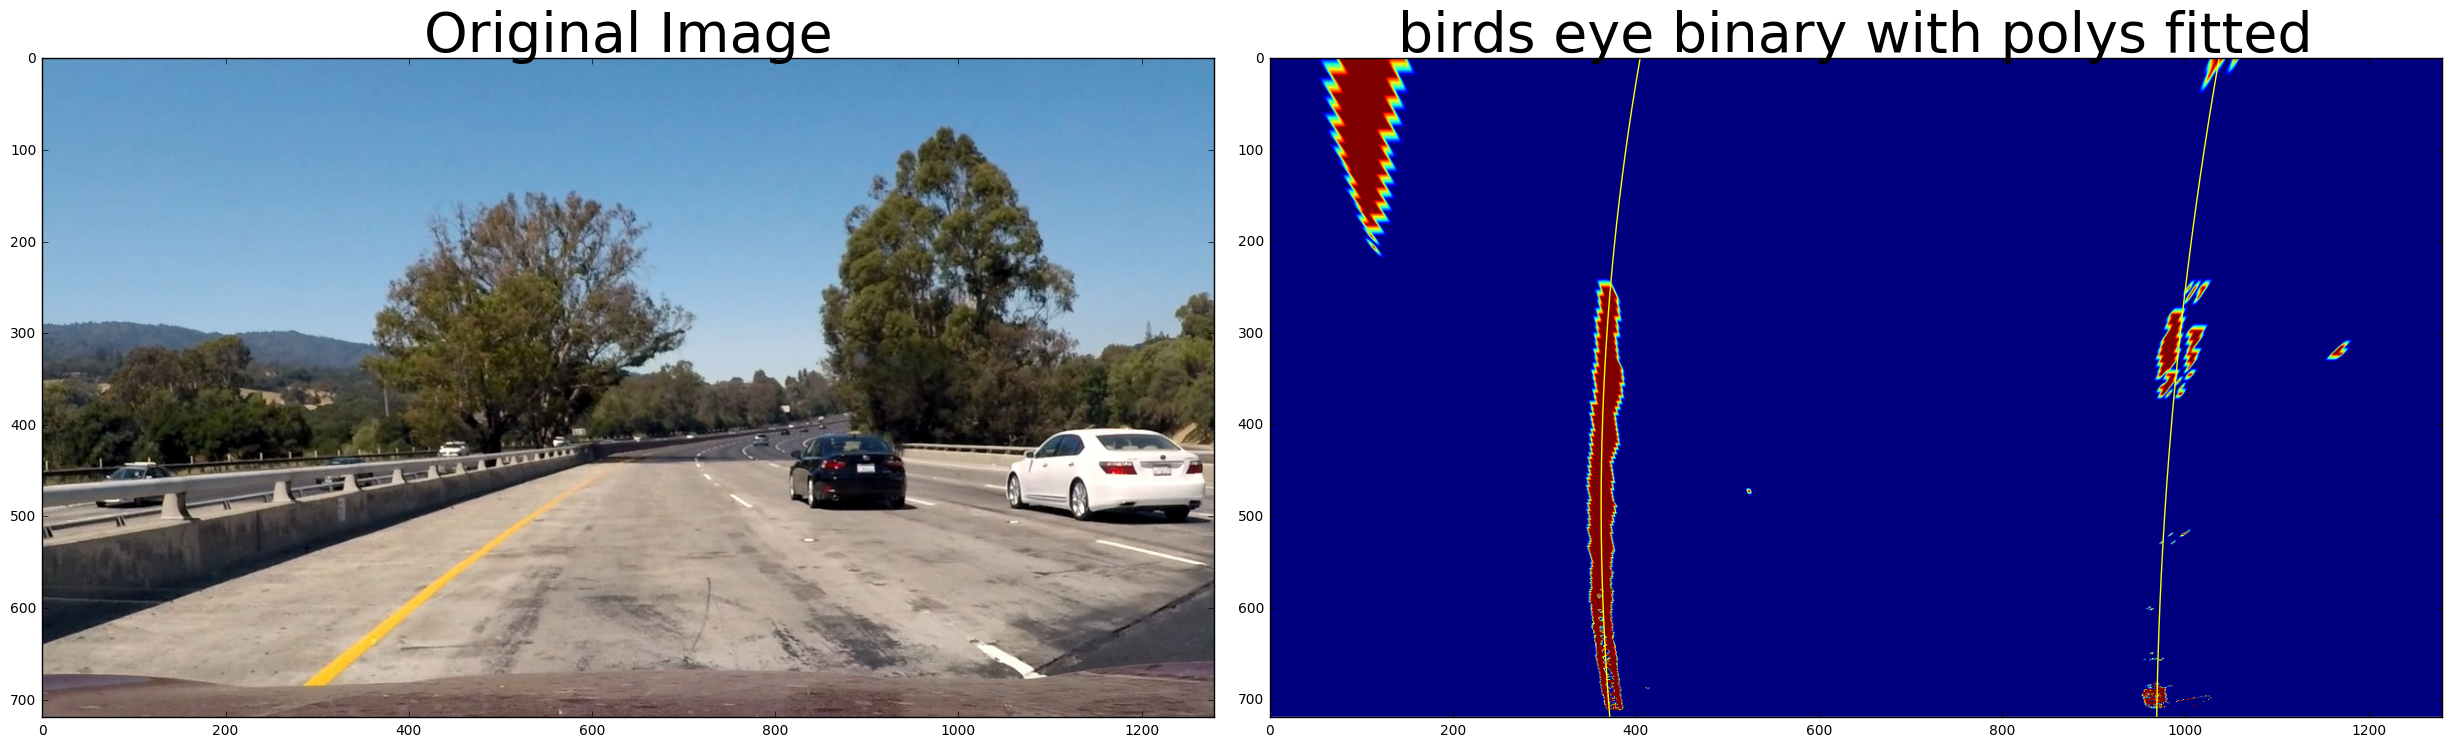

In [13]:

#undistort
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Apply pipeline to the image to create black and white image
binary_undistorted = pipeline(undistorted)

# For source points use the outer four detected corners
src = np.float32([[580,460],[710,460],[1150,720],[150,720]])

# For destination points, pick some points to be
# a decent fit for displaying the warped result 
dst = np.float32([[310, 0],[960, 0],[960, 720],[310, 720]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()
binary_warped = cv2.warpPerspective(binary_undistorted, M, img_size)


# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_origRGB)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(binary_warped)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
ax2.set_title('birds eye binary with polys fitted', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## lanefinder function 
- takes in an image and undistorts the lens distortion
- applies the pipeline function (which creates a binary image of the lines)
- then cornerpins the lines into a birds eye type view
- creates a histogram of the binary birds eye view
- steps through a window search of the binay and collects the points
- calculates the curvature and distance car is from center of lane
- draws a green laneline box and output text of curvature and center info over the original image 

In [14]:
def lanefinder(image):
    #undistort
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)

    # Apply pipeline to the image to create black and white image
    binary_undistorted = pipeline(undistorted)

    # For source points use the outer four detected corners
    src = np.float32([[580,460],[710,460],[1150,720],[150,720]])

    # For destination points, pick some points to be
    # a decent fit for displaying the warped result 
    dst = np.float32([[310, 0],[960, 0],[960, 720],[310, 720]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    binary_warped = cv2.warpPerspective(binary_undistorted, M, img_size)

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

   
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(left_curverad))
    result = cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    
    
    # find car center position
    pts_a = np.argwhere(newwarp[:,:,1])
    
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position_a = image.shape[1]/2
    
    left  = np.min(pts_a[(pts_a[:,1] < position_a) & (pts_a[:,0] > 700)][:,1])
    right = np.max(pts_a[(pts_a[:,1] > position_a) & (pts_a[:,0] > 700)][:,1])
    center = (left + right)/2
    
    # Define conversions in x and y from pixels space to meters
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension    
    
    position_b = (position_a - center)*xm_per_pix
    
    if position_b < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position_b)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position_b)
    result = cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    
    

    return result


/Users/jason/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


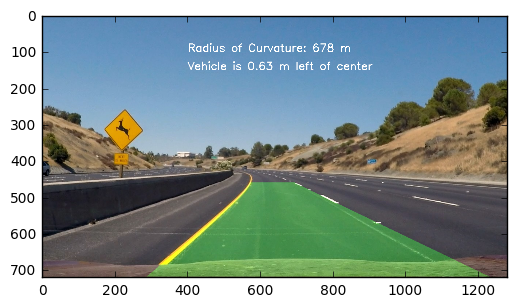

In [15]:
#test lanefinder function
fnametest = 'test_images/test{}.jpg'.format(2)
imagetestBGR = cv2.imread(fnametest)
imageresulttestBGR = lanefinder(imagetestBGR)
imagetestRGB = cv2.cvtColor(imageresulttestBGR, cv2.COLOR_BGR2RGB)

plt.imshow(imagetestRGB)

In [18]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

my_output = 'output_video2.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = VideoFileClip("challenge_video.mp4")
clip3 = VideoFileClip("harder_challenge_video.mp4")

my_clip = clip1.fl_image(lanefinder) #NOTE: this function expects color images!!
%time  my_clip.write_videofile(my_output, audio=False)

[MoviePy] >>>> Building video output_video2.mp4
[MoviePy] Writing video output_video2.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<07:36,  2.76it/s]

  0%|          | 2/1261 [00:00<07:34,  2.77it/s]

  0%|          | 3/1261 [00:01<07:34,  2.77it/s]

  0%|          | 4/1261 [00:01<07:22,  2.84it/s]

  0%|          | 5/1261 [00:01<07:12,  2.90it/s]

  0%|          | 6/1261 [00:02<07:11,  2.91it/s]

  1%|          | 7/1261 [00:02<07:03,  2.96it/s]

  1%|          | 8/1261 [00:02<06:57,  3.00it/s]

  1%|          | 9/1261 [00:03<06:52,  3.04it/s]

  1%|          | 10/1261 [00:03<06:50,  3.05it/s]

  1%|          | 11/1261 [00:03<06:49,  3.05it/s]

  1%|          | 12/1261 [00:04<06:47,  3.06it/s]

  1%|          | 13/1261 [00:04<06:45,  3.08it/s]

  1%|          | 14/1261 [00:04<06:43,  3.09it/s]

  1%|          | 15/1261 [00:04<06:46,  3.06it/s]

  1%|▏         | 16/1261 [00:05<06:44,  3.08it/s]

  1%|▏         | 17/1261 [00:05<06:43,  3.09it/s]

  1%|▏         | 18/1261 [00:05<06:40,  3.10it/s]

  2%|▏         | 19/1261 [00:06<06:50,  3.03it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video2.mp4 

CPU times: user 6min 17s, sys: 2min 1s, total: 8min 18s
Wall time: 7min 32s
